# Task: Optimal Police Car Placement 2025

__Problem Statement:__ The city needs to improve its response times to incidents by optimally locating police cars based on historical incident data (see example in the picture below, this is not real data!).
Your task is to analyze the data and determine the optimal locations for police cars to minimize response times, assuming response time is directly proportional to the straight distance between the police car and the incident. Thus, the objective is to minimize the average distance to incidents, taking into account their priority. <br>

<img src="image.png">

__Input:__
Competition data you can find in the incidents CSV file.
Each row contains:
- latitude - GPS latitude of the incident.
- longitude - GPS longitude of the incident.
- priority - Priority level of the incident (higher value indicates higher priority). 

__Constraints:__

- Number of Police Cars: 10
- Incident priority: higher priority incidents should have more weight in determining optimal locations. An incident with weight 3 is equal to 3 incidents with weight 1.

__Output:__

- Determine the optimal locations of police cars to minimize their average response time to incidents, and put their GPS positions in a single CSV file, containing just latitude and longitude in each row.
- Example output file: <br> 40.664767, -73.917417 <br> 40.654343, -73.920032 <br> 40.663432, -73.915202 <br> 40.673203, -73.912035 <br> 40.663002, -73.923307 <br> 40.654333, -73.924012 <br> 40.642320, -73.919927 <br> 40.662220, -73.917891 <br> 40.654023, -73.921320 <br> 40.663042, -73.920152
- Results CSV file should be submitted via form before the competition deadline



-----------------------------------------------------------------------------------------------------------------

# Solution

### Summary
__Algorithm Used:__
- Centroid-based clustering with Weighted k-Means to determine the optimal locations of police cars.

__Distance Metric:__
- Used Haversine distance to calculate the great-circle distance between geographic points (latitude and longitude), ensuring accuracy for GPS data.

__Centroid Initialization:__
- Implemented k-Means++ initialization to intelligently choose initial centroids, ensuring they are well-spread across the dataset.
- This reduced sensitivity to poor random initialization and improved clustering results.

__Weighted Clustering:__
- Incorporated incident priorities as weights in the clustering process to ensure high-priority incidents had a greater influence on centroid placement.

__Best Random State Selection:__
- Ran the algorithm multiple times with different random states (e.g., random_state=0 to random_state=100).
- Evaluated each random state's performance based on the total weighted response time (sum of weighted distances between incidents and their assigned police car locations).
- Selected random_state=73, which produced the best clustering result with the lowest weighted response time.

__Convergence Criterion:__
- Used centroid shift (change in centroid positions between iterations) to determine convergence.
- Set a tolerance (tol) for small centroid shifts and adjusted the maximum iterations (max_iter) to allow sufficient time for convergence.

__Final Output:__
- The optimal police car locations (centroids) were saved to a CSV file, representing the GPS coordinates that minimize average weighted response time to incidents.

### Step 1: Load the CSV file.

In [1]:
import pandas as pd
import numpy as np

C:\Users\rkw634\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\rkw634\Anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
incidents = pd.read_csv('incidents_2025.csv')
incidents.head()

,latitude,longitude,priority
0,40.671076,-73.962253,2
1,40.691075,-73.916141,5
2,40.625561,-73.978782,1
3,40.617031,-73.973931,1
4,40.617458,-73.961997,1


In [3]:
locations = incidents[['latitude', 'longitude']].values
weights = incidents['priority'].values

### Step 2: Normalize the weights (optional, but helps with stability)

In [4]:
weights = weights / weights.sum()

### Step 3: Perform weighted k-means clustering.
- Harvesine distance for distance between points
- k-Means++ initialization of random centroids to reduce impact of random state
- random state = 73
- max_iteration = 35

In [5]:

# Define a function to calculate Haversine distance
def haversine_distance(point1, point2):
    """
    Calculate the Haversine distance between two points (latitude, longitude).
    Parameters:
       point1, point2: Arrays [lat, lon] in degrees.
    Returns:
       Distance in kilometers.
    """
    # Convert latitude and longitude from degrees to radians
    lat1, lon1 = np.radians(point1)
    lat2, lon2 = np.radians(point2)

    # Differences in latitude and longitude
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Haversine formula
    a = np.sin(dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Radius of Earth in kilometers
    return r * c

def haversine_distances(points, centroids):
    """
    Calculate the pairwise Haversine distances between points and centroids.
    Parameters:
       points: Array of shape (n_points, 2) with latitudes and longitudes.
       centroids: Array of shape (n_clusters, 2) with latitudes and longitudes.
    Returns:
       distances: Array of shape (n_points, n_clusters).
    """
    distances = np.zeros((len(points), len(centroids)))
    for i, point in enumerate(points):
        for j, centroid in enumerate(centroids):
            distances[i, j] = haversine_distance(point, centroid)
    return distances

# Define the k-Means++ initialization function
def kmeans_plus_plus_init(X, n_clusters, random_state=None):
    """
    Initialize cluster centers using the k-Means++ algorithm.
    Parameters:
       X: array of shape (n_samples, n_features), the input data points.
       n_clusters: int, number of clusters.
       random_state: int, random seed for reproducibility.
    Returns:
       centroids: array of shape (n_clusters, n_features), initialized centroids.
    """
    rng = np.random.RandomState(random_state)
    n_samples, n_features = X.shape

    # Step 1: Randomly select the first centroid
    centroids = np.empty((n_clusters, n_features))
    first_idx = rng.choice(n_samples)
    centroids[0] = X[first_idx]

    # Step 2: Select the remaining centroids
    for i in range(1, n_clusters):
       # Compute the squared distances from the nearest centroid for each point
        distances = np.min(np.linalg.norm(X[:, np.newaxis] - centroids[:i], axis=2)**2, axis=1)

       # Compute probabilities proportional to the squared distances
        probabilities = distances / distances.sum()

       # Select the next centroid based on these probabilities
        next_idx = rng.choice(n_samples, p=probabilities)
        centroids[i] = X[next_idx]

    return centroids

In [6]:
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin

class WeightedKMeans:
    def __init__(self, n_clusters, max_iter=300, tol=1e-7, random_state=None):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.cluster_centers_ = None

    def fit(self, X, sample_weight):
        # Initialize cluster centers        
        self.cluster_centers_ = kmeans_plus_plus_init(X, self.n_clusters, random_state=self.random_state)


        for iteration in range(self.max_iter):
            
            # Step 1: Assign each point to the nearest cluster center            
            distances = haversine_distances(X, self.cluster_centers_)
            labels = np.argmin(distances, axis=1)      
                
            # Step 2: Update cluster centers based on weighted mean
            new_cluster_centers = []  # Initialize as a Python list
            for i in range(self.n_clusters):
                # Select points belonging to cluster i
                cluster_points = X[labels == i]
                cluster_weights = sample_weight[labels == i]

                if len(cluster_points) > 0:
                    # Compute weighted centroid                    
                    weighted_lat = np.average(cluster_points[:, 0], weights=cluster_weights)
                    weighted_lon = np.average(cluster_points[:, 1], weights=cluster_weights)
                    new_cluster_centers.append([weighted_lat, weighted_lon])            
                else:
                    # If no points in cluster, retain the old centroid
                    new_cluster_centers.append(self.cluster_centers_[i])

            # Convert the list to a numpy array
            new_cluster_centers = np.array(new_cluster_centers)
            

            # Step 3: Compute shift (Euclidean distance between old and new centroids)
            shift = np.linalg.norm(new_cluster_centers - self.cluster_centers_)
            # print(f"Iteration {iteration + 1}, Centroid Shift: {shift:.6f}")

            # Update centroids
            self.cluster_centers_ = new_cluster_centers

            # Check for convergence (if centroids shift less than tolerance)
            if shift < self.tol:
                break
                         
           # If max iterations reached without convergence, log a message
            if iteration + 1 == self.max_iter:
                print(f"Algorithm stopped after reaching max_iter = {self.max_iter}. Consider increasing max_iter.")

        return self


In [7]:
# Perform weighted k-means clustering
weighted_kmeans = WeightedKMeans(n_clusters=10, max_iter=35, tol=1e-4, random_state=73)
weighted_kmeans.fit(locations, weights)

# Get the cluster centers (police car locations)
police_car_locations = weighted_kmeans.cluster_centers_

### Step 4: Visualize output

[1 2 3 4 5]


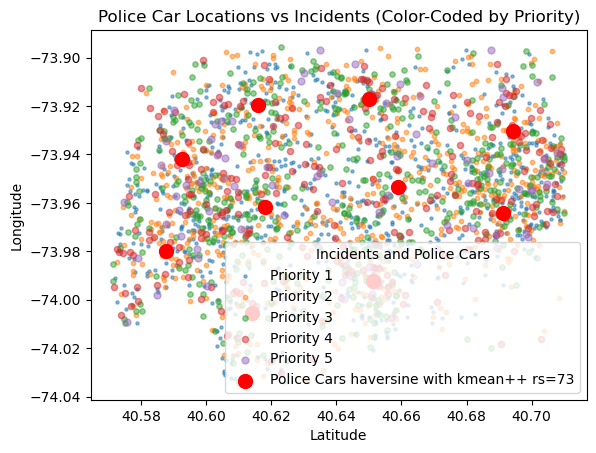

In [8]:
import matplotlib.pyplot as plt

# Assuming the locations, weights, and police_car_locations are already calculated from the Weighted k-Means implementation

# Example data (replace these with your actual outputs from the Weighted k-Means implementation)
# These would normally come from your dataset and clustering results

# Plot incidents color-coded by priority
locations = incidents[['latitude', 'longitude']].values
weights = incidents['priority'].values

unique_priorities = np.unique(weights)  # Get unique priority levels
print(unique_priorities)
for priority in unique_priorities:
   # Filter locations based on the current priority
    mask = weights == priority
    plt.scatter(
       locations[mask, 0],  # Latitude
       locations[mask, 1],  # Longitude
       s=priority * 5,    # Scale size by priority
       alpha=0.5,
       label=f'Priority {priority}'  # Add priority to legend
   )

# Plot police car locations
plt.scatter(
   police_car_locations[:, 0],  # Latitude
   police_car_locations[:, 1],  # Longitude
   c='red',
   s=100,  # Larger size for police car locations
   label='Police Cars haversine with kmean++ rs=73'
)


# Add labels and title
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.legend(title="Incidents and Police Cars")  # Add a title to the legend
plt.title('Police Car Locations vs Incidents (Color-Coded by Priority)')
plt.show()

### Step 5: Save output to csv

In [9]:
police_car_locations

array([[ 40.69420027, -73.93037168],
       [ 40.61428734, -74.00536955],
       [ 40.59276941, -73.94195902],
       [ 40.6181657 , -73.96174009],
       [ 40.6159252 , -73.91962237],
       [ 40.65122958, -73.99221234],
       [ 40.58775946, -73.97998307],
       [ 40.69129354, -73.96423834],
       [ 40.65889308, -73.95330287],
       [ 40.65013587, -73.91699148]])

In [10]:
df = pd.DataFrame(police_car_locations, columns=['latitude', 'longitude'])

# Save the DataFrame to a CSV file
output_file = 'police_car_locations.csv'
df.to_csv(output_file, index=False)